Try 50 slices as an interval

P.S.: the "vmax" in MI plots are set up for visual purposes; check its statistics for accurate info

path: 

/xdisk/chanc/share/

there are two folders: GRMHD_dt1000M and GRMHD_dt10M

under GRMHD_dt1000M: Ma+0.5_w5  Ma+0.94_w5  Ma-0.5_w5  Ma-0.94_w5  Ma0_w5  Sa+0.5_w5  Sa+0.94_w5  Sa-0.5_w5  Sa-0.94_w5  Sa0_w5

under GRMHD_dt10M: Ma+0.94_w5  Ma-0.94_w5  Sa+0.94_w5, 5000 - 5999

In [1]:
import warnings

from toolz import valmap

import h5py
import pyharm

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyharm.plots import plot_dumps as pplt

In [2]:
pyharm.units.get_cgs()

{'CL': 29979245800.0,
 'QE': 4.8032068e-10,
 'EE': 4.8032068e-10,
 'ME': 9.1093826e-28,
 'MP': 1.67262171e-24,
 'MN': 1.67492728e-24,
 'HPL': 6.6260693e-27,
 'HBAR': 1.0545717e-27,
 'KBOL': 1.3806505e-16,
 'GNEWT': 6.6742e-08,
 'SIG': 5.6704e-05,
 'AR': 7.5657e-15,
 'THOMSON': 6.65245873e-25,
 'JY': 1e-23,
 'PC': 3.085678e+18,
 'AU': 14959787069100.0,
 'MSOLAR': 1.989e+33,
 'RSOLAR': 69600000000.0,
 'LSOLAR': 3.827e+33}

In [3]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16

In [6]:
# R
def R(dump, Rh, Rl):
    # with warnings.catch_warnings(record=True) as w:
    '''
    try: 
        beta = dump['beta']
    except RuntimeWarning as warning:
        if str(warning) == "divide by zero encountered in true_divide":
            beta = np.zeros(dump['Pg'])
    '''
    beta = dump['beta']
    return Rl/(1+beta**2)+Rh*beta**2/(1+beta**2)

In [7]:
# electron temperature
def Te(dump, Rh, Rl, gamma):
    if gamma == 4/3:
        y = 1
        z = 3
        gamma_i = 4/3
        gamma_e = 7/3
    if gamma == 13/9:
        y = 1
        z = 2
        gamma_i = 13/9
        gamma_e = 133/36
    if gamma == 5/3:
        y = 1
        z = 1
        gamma_i = 5/3
        gamma_e = 5/3
    beta = dump['beta']
    u = dump['Pg']/(gamma-1)
    r = R(dump, Rh, Rl)
    numerator = mp*cl**2*u*(gamma_e-1)*(gamma_i-1)
    denom = kb*dump['RHO']*(y*(gamma_i-1)+r*z*(gamma_e-1))
    '''
    try:
        electron_T = numerator/ denom
    except RuntimeWarning as warning:
        if str(warning) == "invalid value encountered in true_divide":
            electron_T = np.full(numerator.shape, 10**10)
    '''
    electron_T = numerator/ denom
    dump.cache['Te'] = electron_T
    return electron_T

In [8]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [9]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

In [10]:
def average(irange, keys, dumps):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [11]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    # return valmap(lambda v: v/len(irange), ss)

In [12]:
def change_Rh(i0, i1, src, idx, gamma=4/3):
    """
    src: str, path to the folder
    idx: int, corresponds to the index of the R_high list
    """
    dumps = get_dumps(i0, i1, src)
    Te_rh = {} 
    dict_keys = dumps.keys()
    for key in dict_keys:
        temp = Te(dumps[key], R_high[idx], R_low, gamma)
        Te_rh[key] = temp
    dump0 = pyharm.load_dump(fname(i0, src))
    print('finish reading in dumps')
    Te_avg = average(range(i0, i1), ['Te'], dumps)
    for dump in dumps.values():
        dump.cache['avgTe'] = np.squeeze(np.array(list(Te_avg.values())))
    variance(range(i0, i1), dumps)
    return dumps

In [13]:
def MI(dumps, i0, quality='Te'):
    avg = 'avg' + quality
    std = 'std' + quality
    dumps[str(i0)].cache['MI('+ quality +')'] = dumps[str(i0)].cache[std]/dumps[str(i0)].cache[avg]

In [14]:
def get_statistics(dumps, quality):
    """
    dumps: the dumps' dictionary in the format of dumps={'5010':arr1, '5011':arr2, etc}
    quality: string, the quality whose statistics we want 
    """
    print('statistics on ' + quality + ':')
    print('max ' + quality + ':')
    maximum = np.max(dumps[str(i0)].cache[quality])
    print("{:e}".format(maximum))
    print('percentile on ' + quality+ ' [50%, 75%, 90%]:')
    # percentile of the flattened grid
    percentile = np.percentile(dumps[str(i0)].cache[quality], [50, 75, 90])
    print(percentile)

# $\gamma = \frac{4}{3}$, $\beta$ and Te, $\sigma$ and MI

MAD model, $R_{high} = 1$

In [15]:
# electron temperature, mad model, R_high = 1
dumps_ma = get_dumps(i0, i1, src_ma_10M)
Te_mad_rh1 = {} 
dict_keys = dumps_ma.keys()
for key in dict_keys:
    Te_ma = Te(dumps_ma[key], R_high[0], R_low, 4/3)
    Te_mad_rh1[key] = Te_ma

In [16]:
dump0 = pyharm.load_dump(fname(i0, src_ma_10M))

In [17]:
# average
Te_Ma_avg1 = average(range(i0, i1), ['Te'], dumps_ma)
for dump in dumps_ma.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Ma_avg1.values())))

finish average calculation.


In [18]:
print(dumps_ma[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe'])


In [38]:
# variance & standard deviation
variance(range(i0, i1), dumps_ma)
dumps_ma_std = np.sqrt(dumps_ma[str(i0)].cache['varTe'])
for dump in dumps_ma.values():
    dump.cache['stdTe'] = dumps_ma_std

finish variance & standard deviation calculation's loop.


In [24]:
print(dumps_ma[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe', 'varTe', 'stdTe'])


In [55]:
get_statistics(dumps_ma, 'avgTe')
print()
get_statistics(dumps_ma, 'stdTe')

statistics on avgTe:
max avgTe:
3.997252e+12
percentile on avgTe [50%, 75%, 90%]:
[4.03087398e+10 2.79338256e+11 5.25361499e+11]

statistics on stdTe:
max stdTe:
2.447476e+13
percentile on stdTe [50%, 75%, 90%]:
[5.07652012e+10 7.18508011e+11 1.39847566e+12]


In [47]:
MI(dumps_ma, i0)
get_statistics(dumps_ma, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
1.799528e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.23224066 2.8312897  4.56965534]


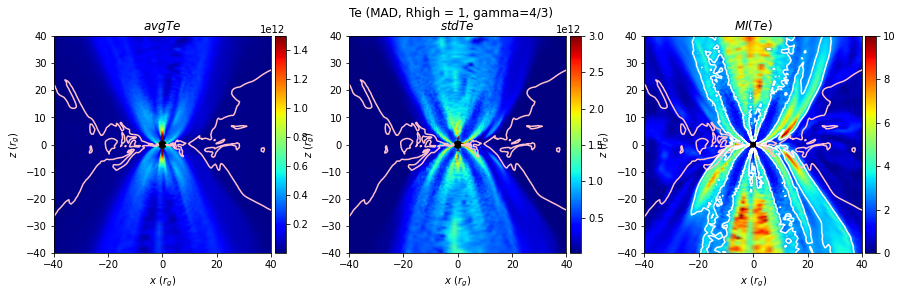

In [58]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_ma[str(i0)], 'avgTe', window=w, vmin=10**7, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps_ma[str(i0)], 'stdTe', window=w, vmin=10**10, vmax=3.*10**12)
pplt.plot_xz(axes[2], dumps_ma[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=10)
pplt.overlay_contours(axes[0], dumps_ma[str(i0)], 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'MI(Te)',(3.0, ), color='white')
plt.suptitle('Te (MAD, Rhigh = 1, gamma=4/3)')
plt.show()

SANE model, $R_{high}$ = 1

In [15]:
# electron temperature, sane model, R_high = 1
dumps_sa = get_dumps(i0, i1, src_sa_10M)
Te_sa_rh1 = {} 
dict_keys = dumps_sa.keys()
for key in dict_keys:
    Te_sa = Te(dumps_sa[key], R_high[0], R_low, 4/3)
    Te_sa_rh1[key] = Te_sa

In [16]:
dump0 = pyharm.load_dump(fname(i0, src_sa_10M))

In [17]:
# average
Te_Sa_avg1 = average(range(i0, i1), ['Te'], dumps_sa)
for dump in dumps_sa.values():
    dump.cache['avgTe'] = np.squeeze(np.array(list(Te_Sa_avg1.values())))

finish average calculation.


In [18]:
print(dumps_sa[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe'])


In [19]:
# variance & standard deviation
variance(range(i0, i1), dumps_sa)
dumps_sa_std = np.sqrt(dumps_sa[str(i0)].cache['varTe'])
for dump in dumps_sa.values():
    dump.cache['stdTe'] = dumps_sa_std

finish variance & standard deviation calculation's loop.


In [20]:
print(dumps_sa[str(i0)].cache.keys())

dict_keys(['Pg', 'Gamma', 'ucon', 'ucov', 'bcon', 'bcov', 'bsq', 'Pb', 'beta', 'Te', 'avgTe', 'varTe', 'stdTe'])


In [21]:
get_statistics(dumps_sa, 'avgTe')
print()
get_statistics(dumps_sa, 'varTe')
print()
get_statistics(dumps_sa, 'stdTe')

statistics on avgTe:
max avgTe:
1.129500e+12
percentile on avgTe [50%, 75%, 90%]:
[2.04498610e+10 8.01273437e+10 1.55742015e+11]

statistics on varTe:
max varTe:
1.335531e+25
percentile on varTe [50%, 75%, 90%]:
[6.66085384e+19 4.95586641e+21 1.77630307e+23]

statistics on stdTe:
max stdTe:
3.654492e+12
percentile on stdTe [50%, 75%, 90%]:
[8.16140542e+09 7.03979148e+10 4.21462106e+11]


In [23]:
MI(dumps_sa, i0)
get_statistics(dumps_sa, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
1.410838e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.39817932 0.86398059 2.8302097 ]


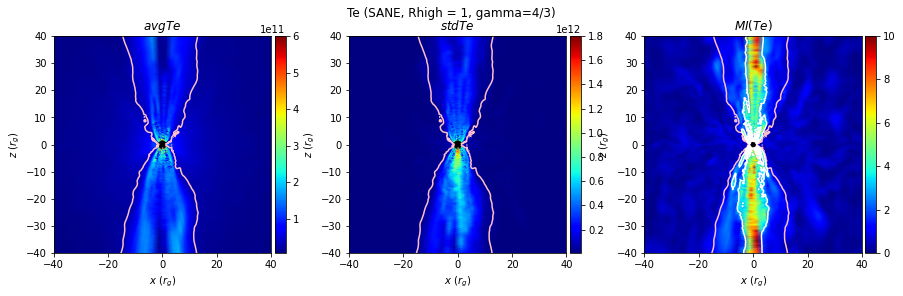

In [26]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'avgTe', window=w, vmin=5*10**9, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'stdTe', window=w, vmin=4*10**9, vmax=1.8*10**12)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=10)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 10$

In [15]:
# MAD, R_h = 10
dumps_rh10 = change_Rh(i0, i1, src_ma_10M, 1)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
dumps_rh10_std = np.sqrt(dumps_rh10[str(i0)].cache['varTe'])
for dump in dumps_rh10.values():
    dump.cache['stdTe'] = dumps_rh10_std

In [17]:
print('statistics on avgTe:')
print('max avgTe:')
maximum = np.max(dumps_rh10[str(i0)].cache['avgTe'])
print("{:e}".format(maximum))
print('percentile on avgTe [25%, 50%, 75%]:')
# percentile of the flattened grid
percentile = np.percentile(dumps_rh10[str(i0)].cache['avgTe'], [25, 50, 75])
print(percentile)

statistics on avgTe:
max avgTe:
3.957489e+12
percentile on avgTe [25%, 50%, 75%]:
[1.14038996e+09 1.25498601e+10 2.48902321e+11]


In [19]:
get_statistics(dumps_rh10, 'stdTe')

statistics on stdTe:
max stdTe:
1.322973e+13
percentile on stdTe [50%, 75%, 90%]:
[3.37944694e+10 6.89390042e+11 1.35513303e+12]


In [20]:
MI(dumps_rh10, i0)

In [22]:
get_statistics(dumps_rh10, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
2.421502e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.52089022 3.65810462 5.66166166]


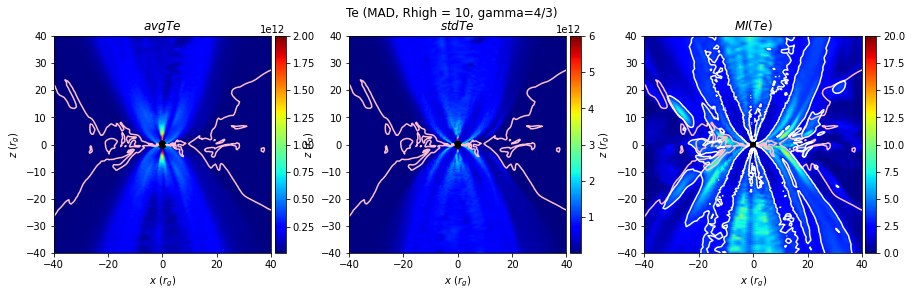

In [24]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh10[str(i0)], 'avgTe', window=w, vmin=5e9, vmax=2*10**12)
pplt.plot_xz(axes[1], dumps_rh10[str(i0)], 'stdTe', window=w, vmin=4e9, vmax=6.*10**12)
pplt.plot_xz(axes[2], dumps_rh10[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=20)
pplt.overlay_contours(axes[0], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh10[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 10, gamma=4/3)')
plt.show()

SANE model, $R_{high} = 10$

In [15]:
# SANE, R_h = 10 (idx=1)
dumps_sa_rh10 = change_Rh(i0, i1, src_sa_10M, 1)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
dumps_sa_rh10_std = np.sqrt(dumps_sa_rh10[str(i0)].cache['varTe'])
for dump in dumps_sa_rh10.values():
    dump.cache['stdTe'] = dumps_sa_rh10_std

In [17]:
get_statistics(dumps_sa_rh10, 'avgTe')
print()
get_statistics(dumps_sa_rh10, 'varTe')
print()
get_statistics(dumps_sa_rh10, 'stdTe')

statistics on avgTe:
max avgTe:
1.084082e+12
percentile on avgTe [50%, 75%, 90%]:
[2.39669880e+09 1.39331286e+10 1.22006933e+11]

statistics on varTe:
max varTe:
1.073672e+25
percentile on varTe [50%, 75%, 90%]:
[9.99687374e+17 3.23326738e+20 1.77739527e+23]

statistics on stdTe:
max stdTe:
3.276694e+12
percentile on stdTe [50%, 75%, 90%]:
[9.99843675e+08 1.79812886e+10 4.21591659e+11]


In [18]:
MI(dumps_sa_rh10, i0)

In [20]:
get_statistics(dumps_sa_rh10, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
2.212697e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.40677423 1.18194208 3.94294619]


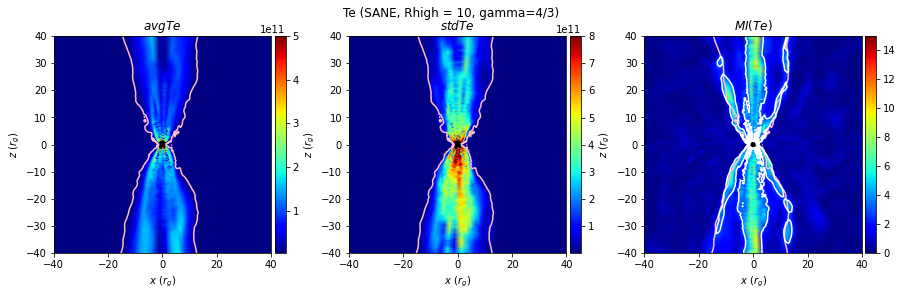

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh10[str(i0)], 'avgTe', window=w, vmin=2e9, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh10[str(i0)], 'stdTe', window=w, vmin=5e8, vmax=8e11)
pplt.plot_xz(axes[2], dumps_sa_rh10[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=15)
pplt.overlay_contours(axes[0], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh10[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 10, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 40$

In [15]:
# MAD, R_h = 40
dumps_rh40 = change_Rh(i0, i1, src_ma_10M, 2)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [17]:
dumps_rh40_std = np.sqrt(dumps_rh40[str(i0)].cache['varTe'])
for dump in dumps_rh40.values():
    dump.cache['stdTe'] = dumps_rh40_std

In [18]:
get_statistics(dumps_rh40, 'avgTe')
print()
get_statistics(dumps_rh40, 'stdTe')

statistics on avgTe:
max avgTe:
3.832159e+12
percentile on avgTe [50%, 75%, 90%]:
[4.96572526e+09 2.36068062e+11 4.88379567e+11]

statistics on stdTe:
max stdTe:
1.067272e+13
percentile on stdTe [50%, 75%, 90%]:
[1.84976526e+10 6.76571304e+11 1.35660843e+12]


In [19]:
MI(dumps_rh40, i0)
get_statistics(dumps_rh40, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.307747e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.61390877 4.17117741 7.06498111]


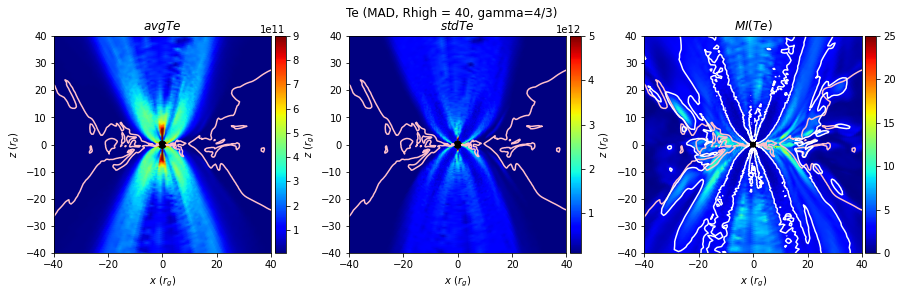

In [22]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh40[str(i0)], 'avgTe', window=w, vmin=2.5e9, vmax=9*10**11)
pplt.plot_xz(axes[1], dumps_rh40[str(i0)], 'stdTe', window=w, vmin=9e10, vmax=5.*10**12)
pplt.plot_xz(axes[2], dumps_rh40[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=25)

pplt.overlay_contours(axes[0], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh40[str(i0)], 'MI(Te)', (3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 40, gamma=4/3)')
plt.show()

SANE, $R_{high}=40$

In [15]:
# SANE, R_h = 40 (idx=2)
dumps_sa_rh40 = change_Rh(i0, i1, src_sa_10M, 2)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [17]:
dumps_sa_rh40_std = np.sqrt(dumps_sa_rh40[str(i0)].cache['varTe'])
for dump in dumps_sa_rh40.values():
    dump.cache['stdTe'] = dumps_sa_rh40_std

In [18]:
get_statistics(dumps_sa_rh40, 'avgTe')
print()
get_statistics(dumps_sa_rh40, 'stdTe')

statistics on avgTe:
max avgTe:
1.030431e+12
percentile on avgTe [50%, 75%, 90%]:
[6.06836378e+08 3.95886572e+09 1.14748760e+11]

statistics on stdTe:
max stdTe:
2.967901e+12
percentile on stdTe [50%, 75%, 90%]:
[2.55657653e+08 7.01202845e+09 4.14100759e+11]


In [19]:
MI(dumps_sa_rh40, i0)

In [20]:
get_statistics(dumps_sa_rh40, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.281676e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.41536055 1.33712824 4.71887029]


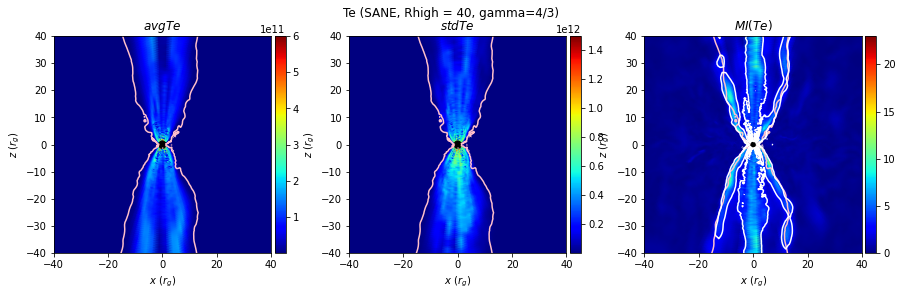

In [22]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh40[str(i0)], 'avgTe', window=w, vmin=3*10**8, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh40[str(i0)], 'stdTe', window=w, vmin=10**8, vmax=1.5*10**12)
pplt.plot_xz(axes[2], dumps_sa_rh40[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=23)

pplt.overlay_contours(axes[0], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh40[str(i0)], 'MI(Te)', (3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 40, gamma=4/3)')
plt.show()

MAD, $R_{high}=160$

In [15]:
# MAD, R_h = 160
dumps_rh160 = change_Rh(i0, i1, src_ma_10M, 3)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
for dump in dumps_rh160.values():
    # if type(dump) is not str:
    dump.cache['stdTe'] = np.squeeze(np.array(list(np.sqrt(dump.cache['varTe']))))

In [17]:
get_statistics(dumps_rh160, 'avgTe')
print()
get_statistics(dumps_rh160, 'stdTe')

statistics on avgTe:
max avgTe:
3.417263e+12
percentile on avgTe [50%, 75%, 90%]:
[1.51986525e+09 2.22584648e+11 4.78441947e+11]

statistics on stdTe:
max stdTe:
9.084893e+12
percentile on stdTe [50%, 75%, 90%]:
[6.62378630e+09 6.58655978e+11 1.34419897e+12]


In [18]:
MI(dumps_rh160, i0)

In [19]:
get_statistics(dumps_rh160, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.930615e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.65745659 4.54388984 8.52754387]


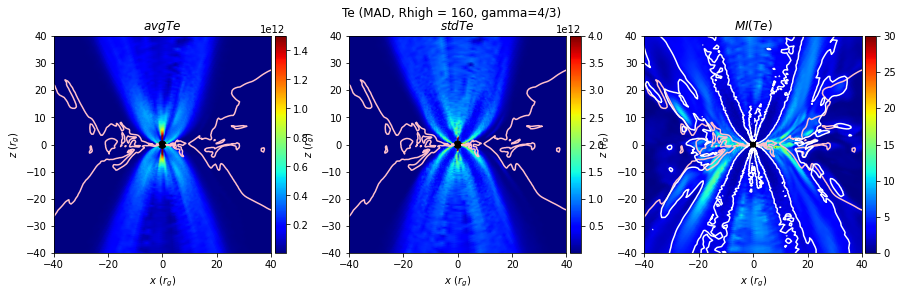

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh160[str(i0)], 'avgTe', window=w, vmin=7*10**8, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps_rh160[str(i0)], 'stdTe', window=w, vmin=3e9, vmax=4e12)
pplt.plot_xz(axes[2], dumps_rh160[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=30)

pplt.overlay_contours(axes[0], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh160[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=4/3)')
plt.show()

SANE, $R_{high}$=160

In [15]:
# SANE, R_h = 160 (idx=3)
dumps_sa_rh160 = change_Rh(i0, i1, src_sa_10M, 3)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
for dump in dumps_sa_rh160.values():
    # if type(dump) is not str:
    dump.cache['stdTe'] = np.squeeze(np.array(list(np.sqrt(dump.cache['varTe']))))

In [17]:
get_statistics(dumps_sa_rh160, 'avgTe')
print()
get_statistics(dumps_sa_rh160, 'stdTe')

statistics on avgTe:
max avgTe:
9.805490e+11
percentile on avgTe [50%, 75%, 90%]:
[1.52223932e+08 1.01558993e+09 1.03078203e+11]

statistics on stdTe:
max stdTe:
2.445387e+12
percentile on stdTe [50%, 75%, 90%]:
[6.43064708e+07 2.26217284e+09 3.95132489e+11]


In [18]:
MI(dumps_sa_rh160, i0)

In [19]:
get_statistics(dumps_sa_rh160, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.736543e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.42208697 1.4181353  5.25534003]


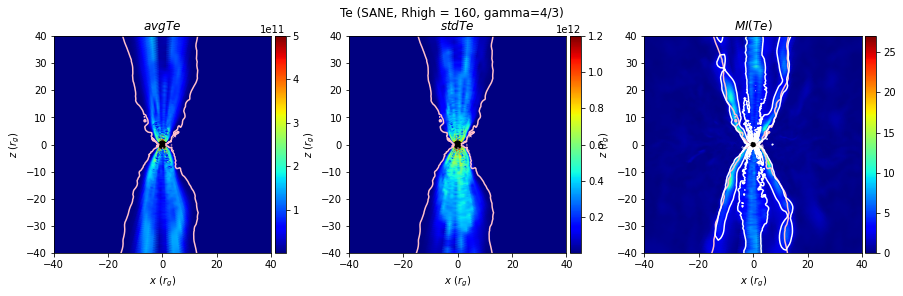

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh160[str(i0)], 'avgTe', window=w, vmin=7.5e7, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh160[str(i0)], 'stdTe', window=w, vmin=3.2e7, vmax=1.2e12)
pplt.plot_xz(axes[2], dumps_sa_rh160[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=27)

pplt.overlay_contours(axes[0], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh160[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 160, gamma=4/3)')
plt.show()

### $\beta$ -MAD

In [17]:
# avg
beta_ma_avg = average(range(i0, i1), ['beta'], dumps_ma)
for dump in dumps_ma.values():
    dump.cache['avgbeta'] = np.squeeze(np.array(list(beta_ma_avg.values())))

finish average calculation.


In [18]:
# variance & standard deviation
variance(range(i0, i1), dumps_ma, 'beta')

beta_ma_std = np.sqrt(dumps_ma[str(i0)].cache['varbeta'])
for dump in dumps_ma.values():
    dump.cache['stdbeta'] = beta_ma_std

finish variance & standard deviation calculation's loop.


In [19]:
beta_ma_log = np.log10(dumps_ma[str(i0)].cache['beta'])
beta_ma_logavg = np.log10(dumps_ma[str(i0)].cache['avgbeta'])
beta_ma_logstd = np.log10(dumps_ma[str(i0)].cache['stdbeta'])
for dump in dumps_ma.values():
    dump.cache['log(beta)'] = beta_ma_log
    dump.cache['log(avgbeta)'] = beta_ma_logavg
    dump.cache['log(stdbeta)'] = beta_ma_logstd

In [20]:
get_statistics(dumps_ma, 'avgbeta')
print()
get_statistics(dumps_ma, 'varbeta')
print()
get_statistics(dumps_ma, 'stdbeta')

statistics on avgbeta:
max avgbeta:
1.791540e+06
percentile on avgbeta [50%, 75%, 90%]:
[  1.58619683  14.81911525 103.59650735]

statistics on varbeta:
max varbeta:
3.303206e+14
percentile on varbeta [50%, 75%, 90%]:
[1.08444134e+01 5.22684160e+03 1.57427999e+05]

statistics on stdbeta:
max stdbeta:
1.817472e+07
percentile on stdbeta [50%, 75%, 90%]:
[  3.29308569  72.29689897 396.77197305]


In [24]:
# MI
MI(dumps_ma, i0, 'beta')
get_statistics(dumps_ma, 'MI(beta)')

statistics on MI(beta):
max MI(beta):
5.049480e+01
percentile on MI(beta) [50%, 75%, 90%]:
[ 3.55110679 10.28843237 20.45656093]


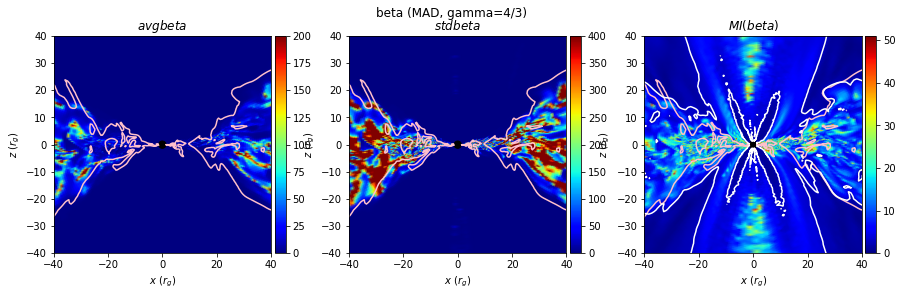

In [67]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_ma[str(i0)], 'avgbeta', window=w, vmin=0., vmax=2e2)
pplt.plot_xz(axes[1], dumps_ma[str(i0)], 'stdbeta', window=w, vmin=0., vmax=4e2)
pplt.plot_xz(axes[2], dumps_ma[str(i0)], 'MI(beta)', window=w, vmin=0., vmax=51)
pplt.overlay_contours(axes[0], dumps_ma[str(i0)], 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'MI(beta)',(3.0, ), color='white')
plt.suptitle('beta (MAD, gamma=4/3)')
plt.show()

In [27]:
get_statistics(dumps_ma, 'log(avgbeta)')
print()
get_statistics(dumps_ma, 'log(stdbeta)')

statistics on log(avgbeta):
max log(avgbeta):
6.253227e+00
percentile on log(avgbeta) [50%, 75%, 90%]:
[0.20035708 1.17082228 2.01534511]

statistics on log(stdbeta):
max log(stdbeta):
7.259468e+00
percentile on log(stdbeta) [50%, 75%, 90%]:
[0.51760303 1.85911967 2.59854099]


In [26]:
dumps_ma[str(i0)].cache['MI(log(beta))'] = dumps_ma[str(i0)].cache['log(stdbeta)']/dumps_ma[str(i0)].cache['log(avgbeta)']
get_statistics(dumps_ma, 'MI(log(beta))')

statistics on MI(log(beta)):
max MI(log(beta)):
7.294232e+05
percentile on MI(log(beta)) [50%, 75%, 90%]:
[0.93403133 1.62663996 2.79598225]


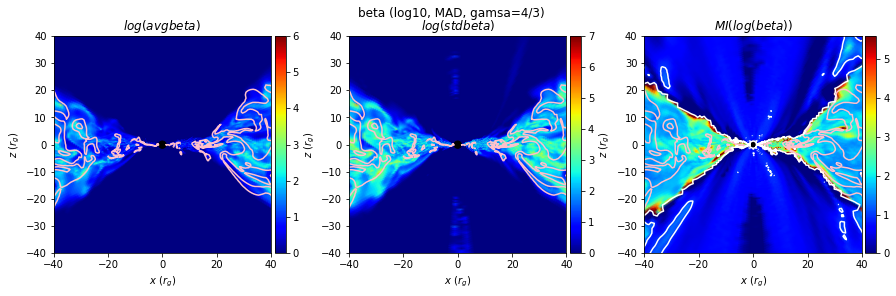

In [28]:
# logscale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_ma[str(i0)], 'log(avgbeta)', window=w, vmin=0., vmax=6.)
pplt.plot_xz(axes[1], dumps_ma[str(i0)], 'log(stdbeta)', window=w, vmin=0., vmax=7.)
pplt.plot_xz(axes[2], dumps_ma[str(i0)], 'MI(log(beta))', window=w, vmin=0., vmax=5.6)
pplt.overlay_contours(axes[0], dumps_ma[str(i0)], 'log(beta)', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_ma[str(i0)], 'log(beta)',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'log(beta)',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'MI(log(beta))',(1.,), color='white')
plt.suptitle('beta (log10, MAD, gamsa=4/3)')
plt.show()

### $\beta$ -SANE

In [17]:
# avg
beta_sa_avg = average(range(i0, i1), ['beta'], dumps_sa)
for dump in dumps_sa.values():
    dump.cache['avgbeta'] = np.squeeze(np.array(list(beta_sa_avg.values())))

finish average calculation.


In [18]:
# variance & standard deviation
variance(range(i0, i1), dumps_sa, 'beta')

beta_sa_std = np.sqrt(dumps_sa[str(i0)].cache['varbeta'])
for dump in dumps_sa.values():
    dump.cache['stdbeta'] = beta_sa_std

finish variance & standard deviation calculation's loop.


In [19]:
beta_sa_log = np.log10(dumps_sa[str(i0)].cache['beta'])
beta_sa_logavg = np.log10(dumps_sa[str(i0)].cache['avgbeta'])
beta_sa_logstd = np.log10(dumps_sa[str(i0)].cache['stdbeta'])
for dump in dumps_sa.values():
    dump.cache['log(beta)'] = beta_sa_log
    dump.cache['log(avgbeta)'] = beta_sa_logavg
    dump.cache['log(stdbeta)'] = beta_sa_logstd

In [20]:
get_statistics(dumps_sa, 'avgbeta')
print()
get_statistics(dumps_sa, 'varbeta')
print()
get_statistics(dumps_sa, 'stdbeta')

statistics on avgbeta:
max avgbeta:
5.021887e+06
percentile on avgbeta [50%, 75%, 90%]:
[ 42.90227864 218.2695992  541.14368243]

statistics on varbeta:
max varbeta:
6.418597e+16
percentile on varbeta [50%, 75%, 90%]:
[1.72752643e+04 6.69443316e+06 6.27712976e+07]

statistics on stdbeta:
max stdbeta:
2.533495e+08
percentile on stdbeta [50%, 75%, 90%]:
[ 131.43539958 2587.36026907 7922.8339382 ]


In [21]:
# MI
MI(dumps_sa, i0, 'beta')
get_statistics(dumps_sa, 'MI(beta)')

statistics on MI(beta):
max MI(beta):
5.049029e+01
percentile on MI(beta) [50%, 75%, 90%]:
[ 6.06851162 14.56015332 21.96000592]


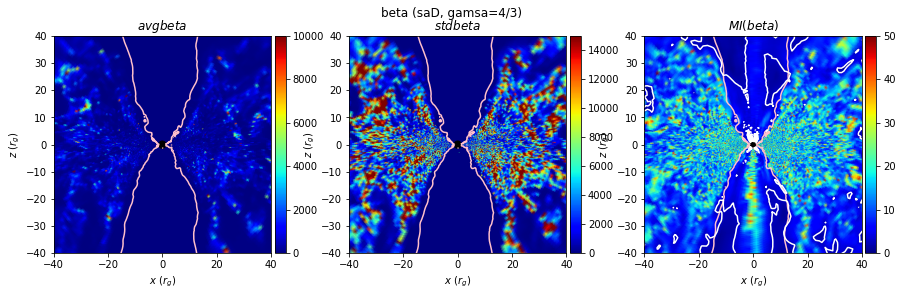

In [32]:
# normal scale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'avgbeta', window=w, vmin=0., vmax=1e4)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'stdbeta', window=w, vmin=0., vmax=1.5e4)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'MI(beta)', window=w, vmin=0., vmax=50)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'MI(beta)',(3.0, ), color='white')
plt.suptitle('beta (SANE, gamma=4/3)')
plt.show()

In [22]:
get_statistics(dumps_sa, 'log(avgbeta)')
print()
get_statistics(dumps_sa, 'log(stdbeta)')

statistics on log(avgbeta):
max log(avgbeta):
6.700867e+00
percentile on log(avgbeta) [50%, 75%, 90%]:
[1.63248036 2.33899325 2.73331259]

statistics on log(stdbeta):
max log(stdbeta):
8.403720e+00
percentile on log(stdbeta) [50%, 75%, 90%]:
[2.11871235 3.4128569  3.89888055]


In [23]:
dumps_sa[str(i0)].cache['MI(log(beta))'] = dumps_sa[str(i0)].cache['log(stdbeta)']/dumps_sa[str(i0)].cache['log(avgbeta)']
get_statistics(dumps_sa, 'MI(log(beta))')

statistics on MI(log(beta)):
max MI(log(beta)):
1.497700e+05
percentile on MI(log(beta)) [50%, 75%, 90%]:
[1.30085462 1.52168443 1.70119262]


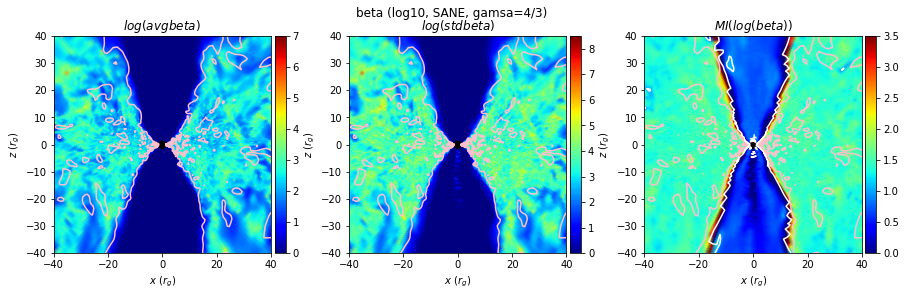

In [24]:
# logscale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'log(avgbeta)', window=w, vmin=0., vmax=7.)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'log(stdbeta)', window=w, vmin=0., vmax=8.5)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'MI(log(beta))', window=w, vmin=0., vmax=3.5)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'log(beta)', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'log(beta)',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'log(beta)',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'MI(log(beta))',(1.,), color='white')
plt.suptitle('beta (log10, SANE, gamsa=4/3)')
plt.show()

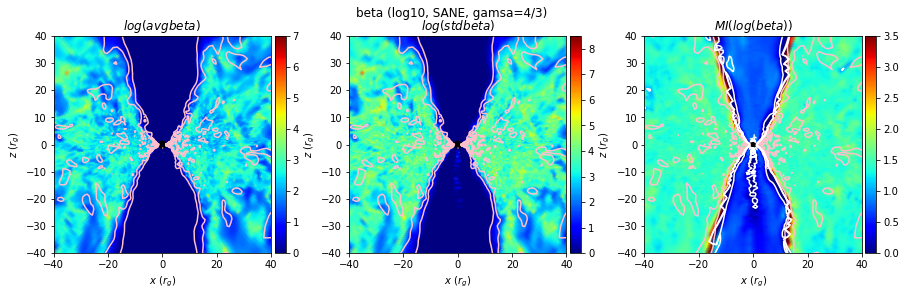

In [25]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'log(avgbeta)', window=w, vmin=0., vmax=7.)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'log(stdbeta)', window=w, vmin=0., vmax=8.5)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'MI(log(beta))', window=w, vmin=0., vmax=3.5)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'log(beta)', (0, 1.), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'log(beta)',(0, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'log(beta)',(0, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'MI(log(beta))',(0, 1.), color='white')
plt.suptitle('beta (log10, SANE, gamsa=4/3)')
plt.show()